In [1]:
from base_dataset import BaseDataset

from torchvision import transforms
import numpy as np
from PIL import Image
import cv2

/home/ubuntu/miniconda3/envs/hrnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = '/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation'
ds = BaseDataset(root_dir, img_dir="images", alpha_dir="masks")

In [21]:
sample = ds[18]

In [22]:
fn, img, trimap, alpha = sample

In [23]:
img.shape, trimap.shape, alpha.shape

(torch.Size([3, 512, 512]),
 torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512]))

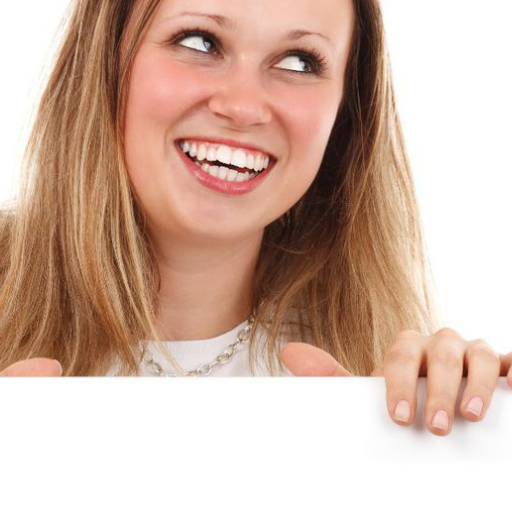

In [24]:
img_np = np.transpose(img, (1, 2, 0)).numpy()
img_np = (img_np * 0.5 + 0.5) * 255.0

Image.fromarray(np.array(img_np, dtype=np.uint8))

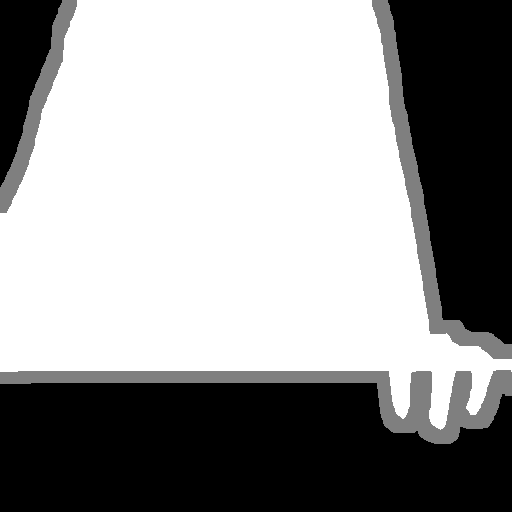

In [25]:
Image.fromarray(np.array(np.squeeze(np.transpose(trimap, (1, 2, 0))).numpy() * 255.0, dtype=np.uint8))

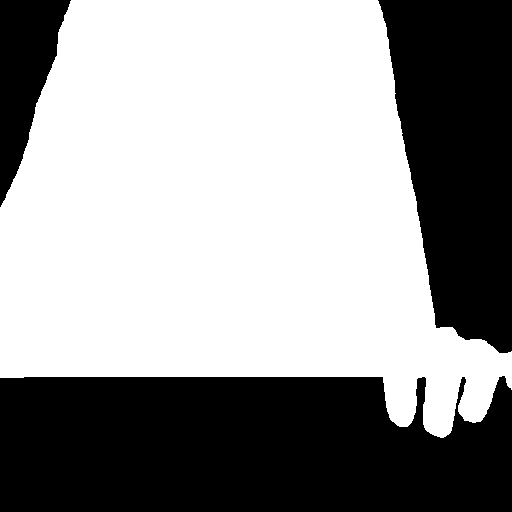

In [26]:
Image.fromarray(np.array(np.squeeze(np.transpose(alpha, (1, 2, 0))).numpy() * 255.0, dtype=np.uint8))

In [27]:
import os

In [51]:
checkpoint_dir = '/home/ubuntu/data/yong/projects/MODNet/pretrained'
checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]

In [52]:
checkpoints

['/home/ubuntu/data/yong/projects/MODNet/pretrained/README.md',
 '/home/ubuntu/data/yong/projects/MODNet/pretrained/mobilenetv2_human_seg.ckpt',
 '/home/ubuntu/data/yong/projects/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt',
 '/home/ubuntu/data/yong/projects/MODNet/pretrained/modnet_photographic_portrait_matting.onnx',
 '/home/ubuntu/data/yong/projects/MODNet/pretrained/modnet_webcam_portrait_matting.ckpt']

In [53]:
latest_checkpoint = max(checkpoints, key=os.path.getctime)

In [54]:
latest_checkpoint

'/home/ubuntu/data/yong/projects/MODNet/pretrained/modnet_webcam_portrait_matting.ckpt'

In [55]:
latest_checkpoint.split(".")[0].split('_')[-1]

'matting'